In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [142]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [143]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,27.270400,50.277000,441.067478,504.986618,213.142605,48.612692,44.301785,62.264359,55.695146,...,274.134124,272.382960,292.908702,284.674020,300.327407,338.392054,355.099971,318.195787,331.833229,510.964081
std,1443.520003,31.164267,37.291495,100.317319,124.823208,193.904553,125.655599,118.445117,140.765392,132.300385,...,122.438175,116.751808,127.561609,122.618575,127.599817,128.578748,130.938946,124.700751,124.592493,134.765917
min,1.000000,1.000000,1.000000,2.323050,2.323050,0.012594,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.318670,0.000000,0.070152,0.381272,0.000000,0.000000,0.000000,0.000000,68.200600
25%,1250.750000,3.000000,10.000000,399.026250,444.919500,50.241575,0.000000,0.000000,0.000000,0.000000,...,186.794000,188.661250,201.041000,199.350000,209.959250,246.423000,263.356750,229.342000,245.758500,419.403500
50%,2500.500000,10.000000,50.000000,449.898000,512.451000,136.976000,0.000000,0.000000,0.000000,0.000000,...,267.080000,265.979000,286.886000,279.336000,295.797000,340.620000,356.528500,315.099000,332.089500,512.309000
75%,3750.250000,50.000000,90.000000,498.686250,578.202250,364.136000,0.000000,0.000000,0.000000,0.000000,...,357.120750,348.827750,378.309500,365.956250,385.806250,426.607250,449.131000,405.675000,417.470000,603.509750
max,5000.000000,90.000000,90.000000,908.713000,935.481000,908.713000,600.449000,585.504000,567.355000,600.653000,...,716.497000,803.999000,775.729000,769.368000,744.813000,751.953000,745.575000,735.556000,727.733000,956.669000


In [144]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

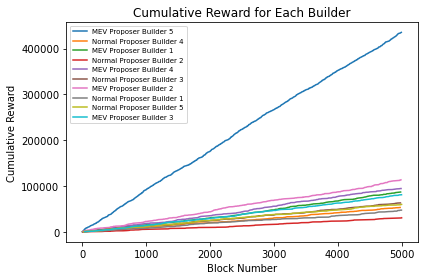

In [145]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

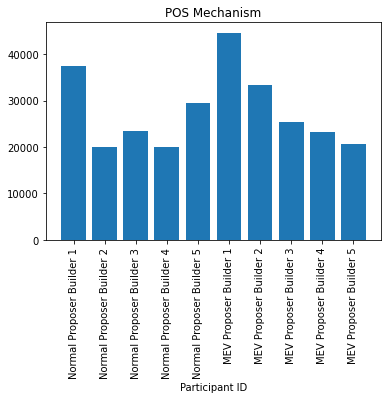

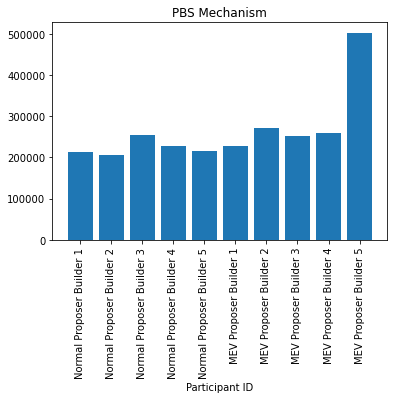

In [146]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id, b_id in zip(df_pbs['Reward'], df_pbs['Builder ID'],df_pbs['Proposer ID']) if id == builder_id & id != b_id]+
                             [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_labels = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_labels, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_labels, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [147]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [148]:
#this is for homogenous builders, 5 extra nodes, 10000 blocks. 
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.12970757613078165
Gini coefficient for POS rewards: 0.154026755831973


In [149]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.10986005515335087
HHI for POS: 0.10813496071221117


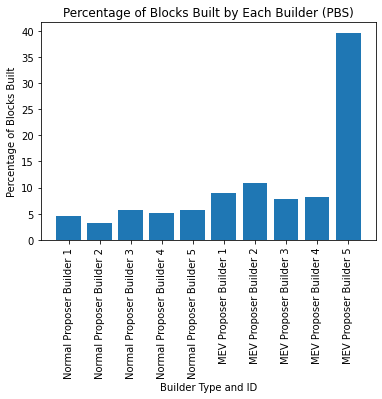

In [150]:
block_counts = [len(df_pbs[df_pbs['Builder ID'] == builder_id]) for builder_id in builder_ids]
block_percentages = [count / len(df_pbs) * 100 for count in block_counts]

plt.bar(builder_labels, block_percentages)
plt.title('Percentage of Blocks Built by Each Builder (PBS)')
plt.xlabel('Builder Type and ID')
plt.ylabel('Percentage of Blocks Built')
# Rotate the x-axis labels
plt.xticks(rotation=90) 
plt.show()
